#**UG Project (VII semester)**






#Analysing feedback and optimising the Welding parameters using ML Algorithms.

---



---



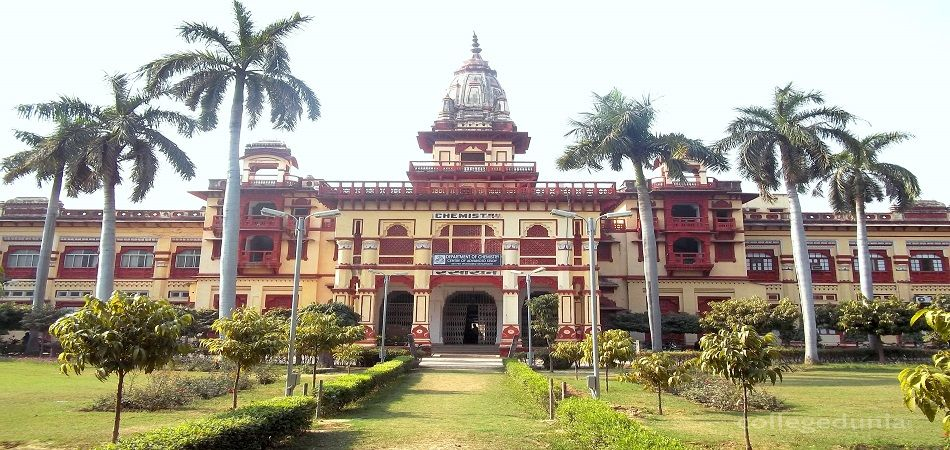

# Objective


*   Analyse and classify the weld quality. ( Done )
*   Based on the quality of the weld optimise the weliding parameters. (To do)



##**Importing all Libraries**

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
import warnings
import pandas as pd
import numpy as np
import datetime
import os
import time
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report
import seaborn as sns
from skimage import data, io, filters
print("All the libraries imported")
print("TensorFlow version:",tf.__version__)
print("TensorFlow Hub version", hub.__version__)

# Check for GPU availability
print("GPU", "available (Yippeeeeee........!)" if tf.config.list_physical_devices("GPU") else "not available:")

All the libraries imported
TensorFlow version: 2.7.0
TensorFlow Hub version 0.12.0
GPU not available:


##**Importing data and converting it into dataframes**



In [ ]:
warnings.filterwarnings('ignore')
train=pd.read_json("/content/drive/MyDrive/UG Project/Data/ss304/ss304/train/train.json",typ='series')
val=pd.read_json("/content/drive/MyDrive/UG Project/Data/ss304/ss304/valid/valid.json",typ='series')
test=pd.read_json("/content/drive/MyDrive/UG Project/Data/ss304/ss304/test/test.json",typ='series')

train=pd.DataFrame(train)
val=pd.DataFrame(val)
test=pd.DataFrame(test)
train.reset_index(inplace=True)
val.reset_index(inplace=True)
test.reset_index(inplace=True)
quality=['good weld','burn through','contamination ','lack of fusion','lack of shielding gas','high travel speed']
train.rename(columns={'index':'filenames',0:'class'},inplace=True)
val.rename(columns={'index':'filenames',0:'class'},inplace=True)
test.rename(columns={'index':'filenames',0:'class'},inplace=True)
train.sort_values(by=['class'],inplace=True,ignore_index=True)
val.sort_values(by=['class'],inplace=True,ignore_index=True)
train.drop([i for i in range(10500)],inplace=True)
train.reset_index(drop=True,inplace=True)
val.drop([i for i in range(5000)],inplace=True)
val.reset_index(drop=True,inplace=True)

for i in range(0,len(train['filenames']),1):
  train['filenames'].loc[i]=str("/content/drive/MyDrive/UG Project/Data/ss304/ss304/train/")+train['filenames'][i]
  
for i in range(0,len(val['filenames']),1):
  val['filenames'].loc[i]=str("/content/drive/MyDrive/UG Project/Data/ss304/ss304/valid/")+val['filenames'][i]

for i in range(0,len(test['filenames']),1):
  test['filenames'].loc[i]=str("/content/drive/MyDrive/UG Project/Data/ss304/ss304/test/")+test['filenames'][i]

train=train.sample(frac=1).reset_index(drop=True)

print(f"dataFrame created with {len(train),len(val),len(test)} datapoints in train, validation and test set respectively")
print(f"columns name: {train.columns}")

dataFrame created with (13704, 4694, 11160) datapoints in train, validation and test set respectively
columns name: Index(['filenames', 'class'], dtype='object')


##**Looking at our data**

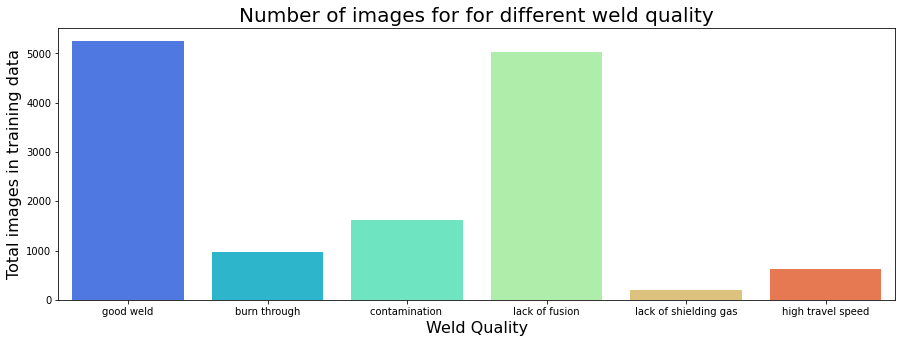

In [ ]:
plt.figure(figsize=(15,5))
ax = sns.countplot(x="class", data=train, palette='rainbow')
ax.set_title("Number of images for for different weld quality",fontsize=20)
ax.set_xlabel("Weld Quality",fontsize=16)
ax.set_ylabel("Total images in training data",fontsize=16)
ax.set(xticks=range(6), xticklabels=[quality[i] for i in range(0,6,1)]);

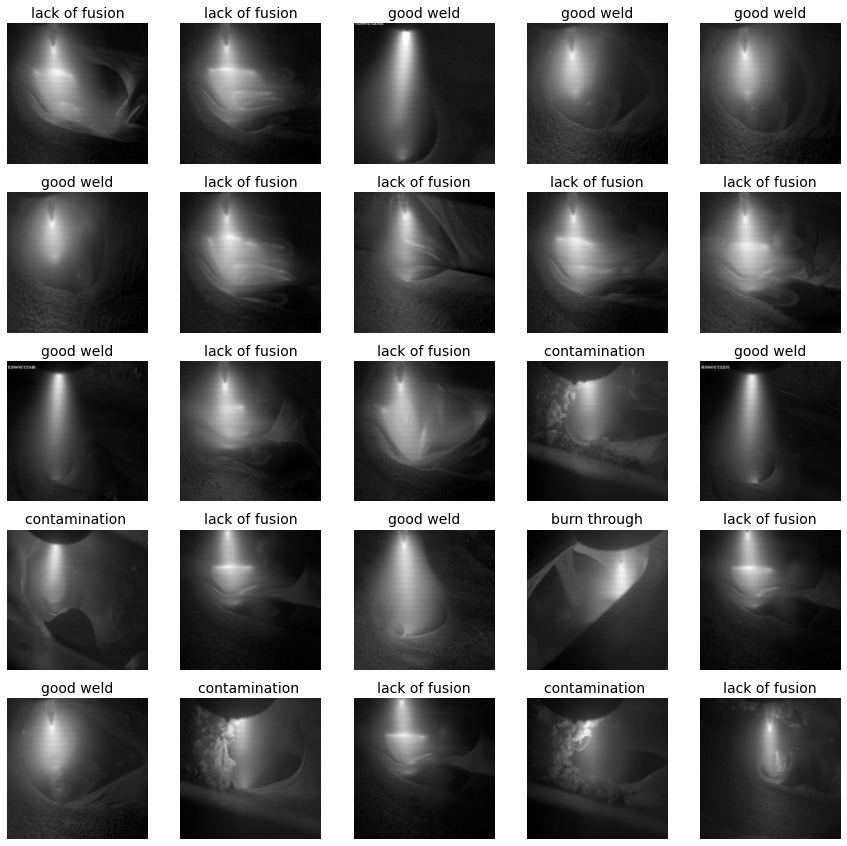

In [ ]:
images,labels=train['filenames'],train['class']
plt.figure(figsize=(15,15))
for i in range(25):
  ax=plt.subplot(5,5,i+1)
  image=tf.io.read_file(train['filenames'][i])
  image=tf.io.decode_png(image, channels=3)
  image=tf.image.convert_image_dtype(image,tf.float32)
  image=tf.image.resize(image,size=[375,375])
  plt.imshow(image)
  plt.title(quality[labels[i]],color='black',fontsize=14)
  plt.axis('off')

##**Creating data batches**

In [ ]:
train_labels=train["class"].to_numpy()
val_labels=val['class'].to_numpy()
test_labels=test['class'].to_numpy()
train_boolean=[label == np.unique(train_labels) for label in train_labels]
val_boolean=[label == np.unique(val_labels) for label in val_labels]
test_boolean=[label == np.unique(test_labels) for label in test_labels]
print("boolean labels created...")

boolean labels created...


In [ ]:
IMG_SIZE=224
def process_image(image_path,img_size=IMG_SIZE):
  print("processing image-------->>>")
  image=tf.io.read_file(image_path)
  image=tf.image.decode_jpeg(image,channels=3)
  # convert the color channels value from 0-255 to 0-1
  image=tf.image.convert_image_dtype(image,tf.float32)
  image=tf.image.resize(image,size=[IMG_SIZE,IMG_SIZE])
  print(f"image processing done----new image size is {(IMG_SIZE,IMG_SIZE)} with 3 colour channels")

  return image
def get_image_label(image_path,label):
  image=process_image(image_path)
  return image,label

BATCH_SIZE=64
def create_data_batches(x,y=None,batch_size=BATCH_SIZE,valid_data=False,test_data=False):
  if test_data:
    print("Creating test data batches...")
    data=tf.data.Dataset.from_tensor_slices(tf.constant(x)) 
    data_batch= data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  elif valid_data:
    print("Creating validation data batches")
    data=tf.data.Dataset.from_tensor_slices((tf.constant(x),
                                             tf.constant(y)))
    data_batch=data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch
  
  else:
    print("Creating Training Data batch")
    data=tf.data.Dataset.from_tensor_slices((tf.constant(x),
                                             tf.constant(y)))
    data=data.shuffle(buffer_size=len(x))
    data=data.map(get_image_label)
    data_batch=data.batch(BATCH_SIZE)
  return data_batch
train_data=create_data_batches(train['filenames'],train_boolean)
val_data=create_data_batches(val['filenames'],val_boolean,valid_data=True)
test_data=create_data_batches(test['filenames'],test_boolean,test_data=True)
print("All data batches created-------->>>>>")

Creating Training Data batch
processing image-------->>>
image processing done----new image size is (224, 224) with 3 colour channels
Creating validation data batches
processing image-------->>>
image processing done----new image size is (224, 224) with 3 colour channels
Creating test data batches...
processing image-------->>>
image processing done----new image size is (224, 224) with 3 colour channels
All data batches created-------->>>>>


##**Creating and training our ML Model**

In [ ]:
INPUT_SHAPE=[None,IMG_SIZE,IMG_SIZE,3] # batch, height, width, colour channels
OUTPUT_SHAPE=6

# Setup model URL from Tensorflow Hub
MODEL_URL="https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

def create_model(input_shape=INPUT_SHAPE,output_shape=OUTPUT_SHAPE,model_url=MODEL_URL):
  print("Building Model with:",MODEL_URL)
  model=tf.keras.Sequential([
                             hub.KerasLayer(MODEL_URL),
                             tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                                                   activation='softmax')
  ])
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy']
  )

  model.build(INPUT_SHAPE)

  return model

model=create_model()
model.summary()
print("Model created.............")

Building Model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 6)                 6012      
                                                                 
Total params: 5,438,725
Trainable params: 6,012
Non-trainable params: 5,432,713
_________________________________________________________________
Model created.............


In [ ]:
%load_ext tensorboard  
def create_tensorboard_callback():
  logdir=os.path.join("/content/drive/MyDrive/UG Project/Tensorboard Results",
                      datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  
  return tf.keras.callbacks.TensorBoard(logdir)

early_stopping= tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                 patience=3)
print("tensorboard is loaded..")

tensorboard is loaded..


In [ ]:
NUM_EPOCHS = 10 #@param {type:"slider", min:10, max:100, step:10}

In [ ]:
def train_model():
  model=create_model()

  tensorboard= create_tensorboard_callback()

  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard,early_stopping])
  
  return model
print("Model is ready for training........")

Model is ready for training........


In [ ]:
def load_model(model_path):
  print("Loading model.......")
  print(f"Loding saved model from: {model_path}")
  model= tf.keras.models.load_model(model_path,
                                   custom_objects={"KerasLayer":hub.KerasLayer})
  print("Done...good to go!!!!!!")
  return model

In [ ]:
def save_model(model,suffix=None):
  print("Saving model.........")
  modeldir=os.path.join("/content/drive/MyDrive/UG Project/Model",
                        datetime.datetime.now().strftime("Y%m%d-%H%M%s"))
  model_path=modeldir + "-"+ suffix +".h5"
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  print(f"Model saved with name {suffix}")
  return model_path

#Be cautious of below lines. Training will take hell lot of time.......
start = time.time()
model=train_model()
save_model(model,suffix="full-model-mobilenetv2-Adam")
end = time.time()
print((end - start)/3600)

Building Model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/10
215/215 [==============================] - 2326s 11s/step - loss: 0.1558 - accuracy: 0.9526 - val_loss: 0.2962 - val_accuracy: 0.9210
Epoch 2/10
215/215 [==============================] - 976s 5s/step - loss: 0.0215 - accuracy: 0.9966 - val_loss: 0.2461 - val_accuracy: 0.9348
Epoch 3/10
215/215 [==============================] - 981s 5s/step - loss: 0.0121 - accuracy: 0.9983 - val_loss: 0.2929 - val_accuracy: 0.9288
Epoch 4/10
215/215 [==============================] - 997s 5s/step - loss: 0.0081 - accuracy: 0.9992 - val_loss: 0.2896 - val_accuracy: 0.9327
Epoch 5/10
215/215 [==============================] - 991s 5s/step - loss: 0.0056 - accuracy: 0.9998 - val_loss: 0.3014 - val_accuracy: 0.9318
Saving model.........
Saving model to: /content/drive/MyDrive/UG Project/Model/Y1112-17431636738990-full-model-mobilenetv2-Adam.h5...
Model saved with name full-model-mobilenetv2-Adam
1.7825

In [ ]:
model=load_model("/content/drive/MyDrive/UG Project/Model/Y1112-17431636738990-full-model-mobilenetv2-Adam.h5")

Loading model.......
Loding saved model from: /content/drive/MyDrive/UG Project/Model/Y1112-17431636738990-full-model-mobilenetv2-Adam.h5
Done...good to go!!!!!!


In [ ]:
model.evaluate(val_data)

74/74 [==============================] - 252s 3s/step - loss: 0.3014 - accuracy: 0.9318


[0.30138659477233887, 0.9318278431892395]

##**Visualizing model predictions on validation set**

In [ ]:
def get_pred_label(prediction_probabilities):
  """
  Turns an array predictions probabilities into a label
  """
  return quality[np.argmax(prediction_probabilities)]
def unbatchify(data,test=False):
  """
  Takes a batch dataset and return separate arrays of images and labels.
  """
  images=[]
  labels=[]
  if test==False:
    for image,label in data.unbatch().as_numpy_iterator():
      images.append(image)
      labels.append(quality[np.argmax(label)])
    return images,labels
  else:
    for image in data.unbatch().as_numpy_iterator():
      images.append(image)
    return images


In [ ]:
val_images,val_labels=unbatchify(val_data)
val_predictions=model.predict(val_data,verbose=1)

175/175 [==============================] - 1315s 8s/step


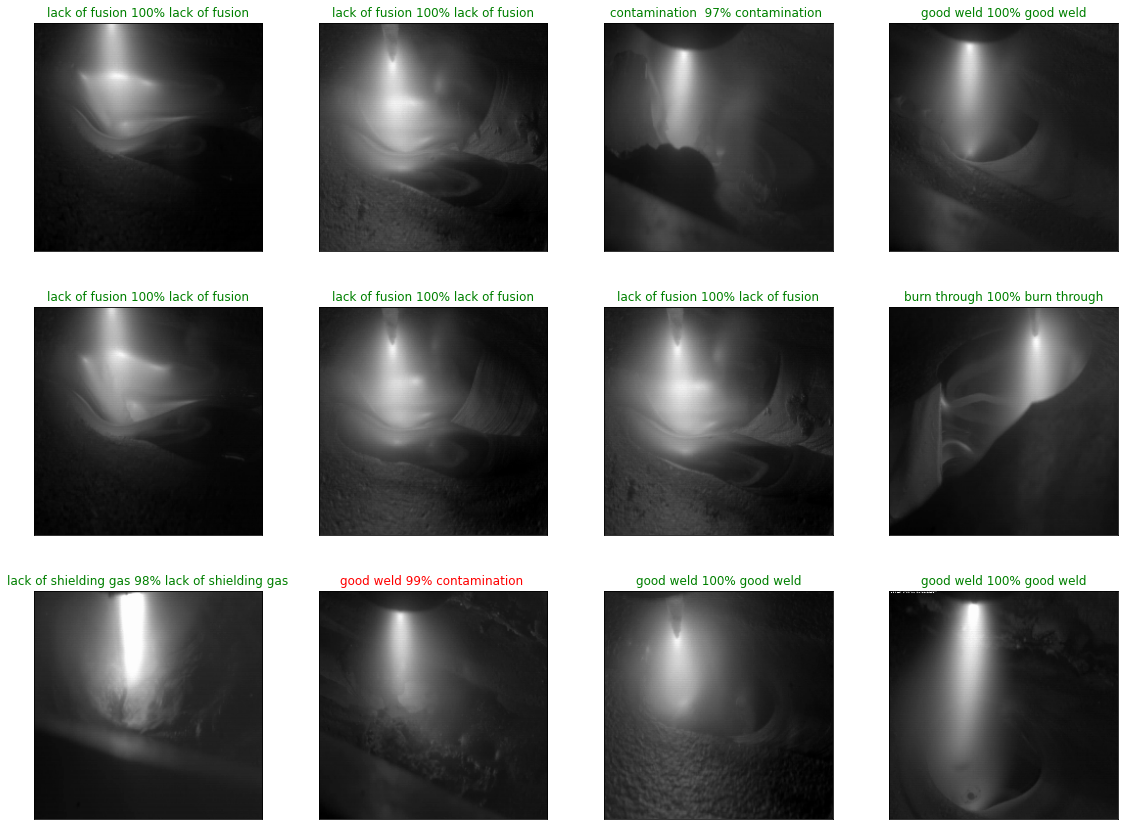

In [ ]:
def plot_pred(prediction_probabilities, labels, images,n=1):
  pred_prob,true_label,image=prediction_probabilities[n], labels[n],images[n]

  pred_label= get_pred_label(pred_prob)

  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  if pred_label==true_label:
    color="green"
  else:
    color= "red"


  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
            color=color)

i_multiplier=21
num_rows=3
num_cols=4
num_images=num_rows*num_cols
plt.figure(figsize=(4*num_cols,4*num_rows))
for i in range (num_images):
  plt.subplot(num_rows,num_cols,i+1)
  plot_pred(prediction_probabilities=val_predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()



*   Green Denotes Correct prediction
*   Red Denotes wrong prediction



In [ ]:
print(classification_report(val_labels, [get_pred_label(val_predictions[i]) for i in range(len(val_labels))]))

                       precision    recall  f1-score   support

         burn through       1.00      0.90      0.95       646
       contamination        0.92      0.39      0.54       339
            good weld       0.88      1.00      0.93      1700
    high travel speed       1.00      0.95      0.97       346
       lack of fusion       0.96      0.99      0.97      1561
lack of shielding gas       1.00      0.94      0.97       102

             accuracy                           0.93      4694
            macro avg       0.96      0.86      0.89      4694
         weighted avg       0.93      0.93      0.92      4694



In [ ]:
print(f"Matthews correlation coefficient for validation set is {matthews_corrcoef(val_labels,[get_pred_label(val_predictions[i]) for i in range(len(val_labels))])}")

Matthews correlation coefficient for validation set is 0.9074474512480271


We are getting a very prestigious score for Matthews correlation coefficient. Hence, our model is up to the mark.

##**Predictions on test images**

In [ ]:
test_images=unbatchify(test_data,test=True)
test_predictions=model.predict(test_data,verbose=1)

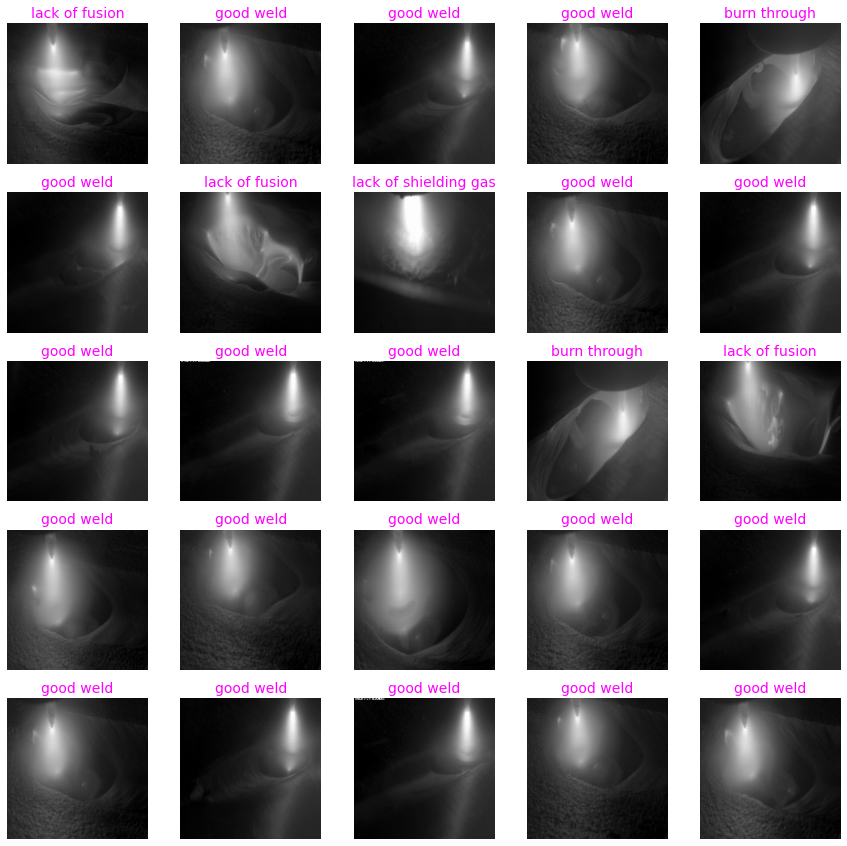

In [ ]:
plt.figure(figsize=(15,15))
for i in range(25):
  ax=plt.subplot(5,5,i+1)
  image=test_images[i]
  plt.imshow(image)
  plt.title(quality[np.argmax(test_predictions[i])],color='magenta',fontsize=14)
  plt.axis('off')

#Contributors 



*   Pushpendra Singh, Roll no. 18134010, IIT BHU
*   Sakshi Tundwal, Roll no. 18135083, IIT BHU
*   Laya Jada, Roll no. 18134022, IIT BHU
*   Sachin Arya, Roll no. 18134012, IIT BHU
*   Narendra Raj, Roll no. 18134007, IIT BHU



#**Thankyou😊😊**